In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,Ridge
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,auc,precision_recall_fscore_support
import joblib 



# Model Training 
In this part we are going to train our model on our selected features using Ridge Regression 


In [4]:
x_train = pd.read_csv('xtrain.csv',index_col=0)
x_test = pd.read_csv('xtest.csv',index_col=0)
y_train = pd.read_csv('ytrain.csv',index_col=0)
y_test = pd.read_csv('ytest.csv',index_col=0)

# checks 
print(x_train.head(1))
print(x_test.head(1))
print(y_train.head(1))
print(y_test.head(1))

   fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  bar  \
0     0.0      1.0             0.0     0.0               0.0   0.0  0.0   

   pluribus  sugarpercent  pricepercent  winpercent  
0       0.0      0.416581       0.32914    0.134388  
   fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  bar  \
0     1.0      0.0             0.0     0.0               0.0   1.0  0.0   

   pluribus  sugarpercent  pricepercent  winpercent  
0       0.0      0.737973      0.024109    0.260468  
   chocolate
0          0
   chocolate
0          0


Then we select our 'selected_features' to train the Model only on them.
So we keep only those features from all the training set 

In [13]:
features = pd.read_csv('selected_features.csv')['0'].to_list()
features


['fruity', 'nougat', 'bar', 'winpercent']

In [15]:
x_train = x_train[features]
x_test = x_test[features]
x_test.head(1)

,fruity,nougat,bar,winpercent
0,1.0,0.0,0.0,0.260468


### <u>Train the Model and remember to set the random_state (seed) to reproduce the model. We also use the same alpha value we used while selecting the features  </u>

In [27]:
ridge_model = Ridge(alpha = 0.09,random_state=0)
ridge_model.fit(x_train,y_train)


Ridge(alpha=0.09, random_state=0)

Then we will make predictions with our model first on the training set and then on the test set .

### TRAINING SET 

<ul><li> Mean Squared Error </li></ul>

In [28]:
y_pred = ridge_model.predict(x_train)

# calculate error 
print (f"Train MSE :{mean_squared_error(y_pred,y_train)}\n" )

Train MSE :0.06734871693392859



<ul><li> R2 score </li></ul>

In [29]:
# calculate regression score 
print (f"Train R2 :{r2_score(y_pred,y_train)}\n" )

Train R2 :0.6190794396098427



### TEST SET 

<ul><li> Mean Squared Error </li></ul>

In [72]:
y_pred = ridge_model.predict(x_test)

# calculate error 
print (f"Test MSE :{mean_squared_error(y_pred,y_test)}\n" )

Test MSE :0.07588501684067529



<ul><li> R2 score </li></ul>

In [73]:
# calculate regression score 
print (f"Test R2 :{r2_score(y_pred,y_test)}\n" )

Test R2 :0.5878699367181376



Since we dealt with the problem as a regression problem we need to cast our continuous predictions to 0 or 1 to select one of the 2 classes . Of course this is not the most logical solution since the problem is actually a classification problem and we have to tackle it with classification algorithms but here we are just experimenting with this regression method and pick a threshold above which we classify as 1 (chocolate) and below as 0 (non chocolate).

In [74]:
y_pred = np.where(y_pred > 0.4,1,0)
y_pred 

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0]])

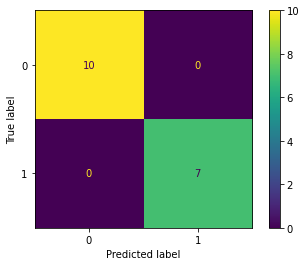

In [75]:
# we need to calculate our confusion matrix here 
cm = confusion_matrix(y_test,y_pred,normalize=None)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [ ]:
# calculate the roc curve and pick a threshold

#fpr,tpr,thresholds = roc_curve(y_test,y_pred,pos_label=1)
#roc_auc = auc(fpr,tpr)
#RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc,estimator_name=ridge_model).plot()
#plt.plot()

If we change the threshold to $(0.4)$ we get correct results but if we increase the threshold or decrease the threshold we start to get more false positives and false negatives. In essence we can't really be certain about the results because we have used a regression technique but the problem is a classification one , so our hardcoded threshold is not really easy to explain and reproduce.

<strong>Next we will use a classification algorithm to tackle the problem </strong>
<ul><li> We will repeat the steps of feature selection and try to pick the best features for our classification task </li></ul>

In [81]:
x_train=pd.read_csv('xtrain.csv',index_col=0)
x_test=pd.read_csv('xtest.csv',index_col=0)
x_train.head()

,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416581,0.329140,0.134388
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.833163,0.670860,0.733322
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.428864,0.950734,0.557461
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.464688,0.475891,0.568434
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.583419,0.110063,0.223635


### We will use linear SVM classifiers to select the best features and then train our SVM classifier model on those selected features.
<strong> Remember to set the random_state to be able to reproduce the model ! </strong>

1. For starters we will use equal weights for both classes (chocolate/non chocolate)
2. Then we will try to select a more appropriate model to take into account the fact that we have class imbalance in our dataset.

In [84]:
from sklearn.svm import LinearSVC

mod = SelectFromModel(estimator=LinearSVC(C=0.04,verbose=1,random_state=0),max_features=len(x_train.columns))
mod.fit(x_train,y_train)


[LibLinear]

/home/ko_st/.pyenv/versions/3.6.15/envs/Py3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SelectFromModel(estimator=LinearSVC(C=0.04, random_state=0, verbose=1),
                max_features=11)

In [85]:
print(f"Coefficients : {mod.estimator_.coef_}\n")

print(f"The returned features are : {x_train.columns[mod.get_support()]}\n")
print(f"The returned indices are : {mod.get_support(indices=True)}")

Coefficients : [[-0.6376343   0.06463582  0.16556075 -0.00399969  0.12511296 -0.14872021
   0.30523837 -0.12066046 -0.00324603  0.16996836  0.31769383]]

The returned features are : Index(['fruity', 'bar', 'winpercent'], dtype='object')

The returned indices are : [ 0  6 10]


In [86]:
selected_features = list(x_train.columns[mod.get_support()])
selected_features

['fruity', 'bar', 'winpercent']

In [87]:
pd.Series(selected_features).to_csv('selected_features.csv',index=False)

In [88]:
features = pd.read_csv('selected_features.csv')['0'].to_list()
features


['fruity', 'bar', 'winpercent']

In [89]:
x_train = x_train[features]
x_test = x_test[features]
x_train.head()

,fruity,bar,winpercent
0,0.0,0.0,0.134388
1,0.0,0.0,0.733322
2,0.0,1.0,0.557461
3,1.0,0.0,0.568434
4,1.0,0.0,0.223635


### Train the Model 

In [90]:
svm_model = LinearSVC(C=0.04,verbose=1,random_state=0)
svm_model.fit(x_train,y_train)


[LibLinear]

/home/ko_st/.pyenv/versions/3.6.15/envs/Py3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LinearSVC(C=0.04, random_state=0, verbose=1)

In [91]:
svm_model.coef_

array([[-0.71462595,  0.42055331,  0.37957564]])

Evaluate the Model on training set

In [96]:
y_pred = svm_model.predict(x_train)

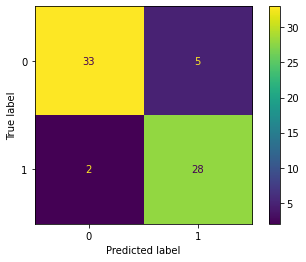

In [100]:
cm = confusion_matrix(y_train,y_pred,normalize=None)

ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm_model.classes_).plot()
plt.show()

Let's evaluate the Model using the <u>precision,recall,fscore</u>:  


In [104]:
print(precision_recall_fscore_support(y_train,y_pred,labels=svm_model.classes_))

(array([0.94285714, 0.84848485]), array([0.86842105, 0.93333333]), array([0.90410959, 0.88888889]), array([38, 30]))
